In [1]:
import os 
#data_location = input("Enter Path Location of data")
os.chdir("/home/mitchell//Documents/masters/masters/scripts/")
import galaxy_pairs
import cmb
os.chdir("/home/mitchell/Documents/masters/masters/data")
cwd = os.getcwd()
print(cwd)

ModuleNotFoundError: No module named 'mpdaf'

In [ ]:
import numpy as np
import scipy as sp
import astropy as ap
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.constants as const
from astropy import constants as ap_const
import scipy.ndimage 
import PIL
from mpdaf.obj import Image,WCS
import sptpol_software as sps
from astropy.io import fits
from astropy.cosmology import Planck15
from astropy import units as u
import scipy.spatial.distance as dist
print(Planck15)
cosmo= Planck15

In [2]:
# from sptpol_software.util.tools import stat
from sptpol_software.observation import *
import sptpol_software.observation as obs
import sptpol_software as sps
import sptpol_software.observation.sky
from sptpol_software.util import files

ModuleNotFoundError: No module named 'constants'

In [3]:
T_cmb = 2.725
freqs_ghz = [93.2000,147.700]
beam_norm_correction = [1./0.99673, 1./0.99470, 1./1. ] 
cal_factors = [0.9097,0.7765] # no 220 is why last is zero. 
#pol_cal_factors = pol_cal_factors_800 * beam_norm_correction

In [10]:
glob.glob('*.h5')

['ra0hdec-57.5_ra0hdec-57p5_20140706_073929_090ghz.h5',
 'ra0dec-57p5_sum1000_090ghz.h5',
 'ra0dec-57p5_sum5000_150ghz.h5',
 'y_map.h5',
 'high_res.h5',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_150ghz.h5',
 'ra0dec-57p5_sum100Weighted_150ghz.h5',
 'ra0dec-57p5_sum1000_150ghz.h5',
 'ra0dec-57p5_sum_150ghz.h5',
 'ra0dec-57p5_sum100Weighted_090ghz.h5',
 'first_coadd_test_fbcode.h5',
 'test.h5',
 'ra0dec-57p5_sum5000_090ghz.h5',
 'ra0dec-57p5_sum_090ghz.h5']

In [6]:
# hdul = fits.open("kmap_mv_run08.fits")
# hdul.info()
# k_map = hdul[0].data


In [7]:
plt.imshow(k_map)

NameError: name 'k_map' is not defined

In [8]:
map_150ghz = files.read("ra0dec-57p5_sum5000_150ghz.h5")
map_90ghz = files.read("high_res.h5")

KeyboardInterrupt: 

In [ ]:
map_90ghz

In [ ]:
# map_150ghz = pol_cal_factors_800[0]*map_150ghz
# map_90ghz = pol_cal_factors_800[1]*map_90ghz
# map_150ghz.mapper_arguments
plt.imshow(k_map)
plt.show()
k_map_rot = np.flipud(k_map)
plt.imshow(k_map_rot)
plt.savefig("lensing_kappa_map")

In [8]:
# map_150ghz.getSubmap([5,5], center_offset=[0,0], units='degree').drawImage(bw=False,vmax=0)
# map_90ghz.getSubmap([10,10], center_offset=[0,0], units='degree').drawImage(bw=False)

In [9]:
# diff_T = map_150ghz-map_90ghz
# diff_T.getSubmap([5,5], center_offset=[1,1], units='degree').drawImage(bw=False)

In [ ]:
# def convert_ghz_to_y(freq_power):
#     x = freq_power/56.85  # x = h v / k_B T_CMB
#     return((x/np.tanh(x/2)) - 4)
print(cmb.convert_ghz_to_y(90))
print(cmb.convert_ghz_to_y(150))

In [ ]:
freq_range = np.arange(20,1000,1)
x = freq_range/56.85
y_param = [(ex/np.tanh(ex/2) - 4) for ex in x]
plt.semilogx(freq_range,y_param,label='Y')
I_v = [(ex**4 * np.exp(ex))/(np.exp(ex)-1)**2 * (ex/np.tanh(ex/2) - 4) for ex in x]
plt.semilogx(freq_range,I_v,label='Intensity')
plt.axhline(0, color='black')
plt.title('Frequency Dependance of SZ Effect')
plt.legend()

In [12]:
# map_150ghz_array = map_150ghz.getTOnly().map
# print(type(map_150ghz))

In [13]:
# freq_scaling = convert_ghz_to_y(150)-convert_ghz_to_y(90)
# print(freq_scaling)
# freq_scaling_fac = 1.0/freq_scaling
# print(freq_scaling_fac)

In [14]:
#y_map = sptpol_software.observation.sky.Map
# y_map = freq_scaling_fac*(map_150ghz-map_90ghz)
#/(convert_ghz_to_y(150)-convert_ghz_to_y(90))

In [11]:
# y_map.getSubmap([5,5], center_offset=[0,0], units='degree').drawImage(bw=True)
# print("Functionally a factor of 2 conversion, look at scale")
# diff_T.getSubmap([2,2], center_offset=[0,0], units='degree').drawImage(bw=False)
y_map_array = cmb.get_y_map([map_150ghz,map_90ghz],cal_factors,freqs_ghz)


In [38]:
wcs1 = WCS(crpix=[len(y_map_array)/2,len(y_map_array[0])/2],crval=[-57.5,0])

In [41]:
test = Image(data=y_map_array,wcs= wcs1)

In [46]:
test.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'LINEAR'  'LINEAR'  
CRVAL : 0.0  -57.5  
CRPIX : 1260.0  660.0  
PC1_1 PC1_2  : 1.0  -0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 2520  1320

In [ ]:
plt.figure()
test.plot(vmax=1e-5,vmin=-1e-5,colorbar='v')
plt.tight_layout()
plt.savefig("compton_y_map")

In [20]:
# y_map.writeToHDF5('y_map.h5',overwrite=True,use_compression=False)
# y_map_array = y_map.getTOnly().map
print(y_map_array)
# np.save('y_map', y_map_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
plt.imshow(y_map_array,vmax=0.00001,vmin=-0.00001)
plt.savefig("compton_y_map")

In [10]:
# red_mapper_cat = fits.open("DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits")
from astropy.table import Table
# dat = Table.read('DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits', format='fits')
# df = dat.to_pandas()

In [11]:
with fits.open("DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits") as data:
    df = pd.DataFrame(data[1].data)

In [12]:
# red_mapper_cat.info()
df

,ID,RA,DEC,ZREDMAGIC,ZREDMAGIC_E,weight
0,3050237433,76.650392,-56.996599,0.150009,0.009600,1.051875
1,3119536009,10.657494,-44.892612,0.150010,0.009513,0.911657
2,3043842585,81.917004,-56.612052,0.150013,0.008653,0.937038
3,3034628499,89.812164,-52.779491,0.150034,0.008681,1.076568
4,3059228029,71.135057,-51.074555,0.150044,0.008685,1.048341
5,3119296447,11.913672,-42.342889,0.150051,0.008591,0.963716
6,3081078666,52.842355,-57.074867,0.150058,0.008494,0.917235
7,3075699929,57.693299,-48.650024,0.150062,0.008151,0.892103
8,3090139698,43.089595,-43.859265,0.150065,0.009137,0.942256
9,3057872589,70.976981,-44.950415,0.150070,0.008823,0.953896


In [13]:
# com_dists = cosmo.comoving_distance(df['ZREDMAGIC']).to_value(u.Mpc)
df['COMOVING'] = pd.Series(cosmo.comoving_distance(df['ZREDMAGIC']).to_value(u.Mpc))
df['COMOVING_E'] = pd.Series(cosmo.comoving_distance(df['ZREDMAGIC_E']).to_value(u.Mpc))

In [13]:
# help(galaxy_pairs.getPairs)

In [14]:
# print(df)
pairs = galaxy_pairs.getPairs(df,20)
# First index is first item in pair
# Second index in second item in pair
# Third Index is distance apart from each other


In [15]:
pairs_df = pd.DataFrame(pairs.T,columns = ['galaxy_index_1','galaxy_index_2','Sep'])
pairs_df['galaxy_index_1'] = pairs_df.galaxy_index_1.astype(int)
pairs_df['galaxy_index_2'] = pairs_df.galaxy_index_2.astype(int)

In [16]:
# print(pairs)
pairs_df

,galaxy_index_1,galaxy_index_2,Sep
0,645602,645787,19.440705
1,651449,652553,12.694922
2,645787,647190,17.268397
3,649428,649606,13.064617
4,649348,649809,19.667827
5,649876,650136,12.081126
6,649876,651213,14.828850
7,649405,649876,8.673922
8,649405,650136,9.708314
9,649809,650136,17.977599


In [17]:
index = np.random.randint(1,len(df))
# print(index)
print(pairs_df.loc[index])
# print(pairs_df.loc[index]['galaxy_index_1'])
print(df.loc[pairs_df.loc[index]['galaxy_index_1']])
print(df.loc[pairs_df.loc[index]['galaxy_index_1']]['RA'])
print(df.loc[pairs_df.loc[index]['galaxy_index_1']]['DEC'])

# print(pairs_df.loc[index]['galaxy_index_2'])
print(df.loc[pairs_df.loc[index]['galaxy_index_2']])
print(df.loc[pairs_df.loc[index]['galaxy_index_2']]['RA'])
print(df.loc[pairs_df.loc[index]['galaxy_index_1']]['DEC'])

# pos1 = [df['RA'][pairs_df['galaxy_index_1'][index]],df['DEC'][pairs_df['galaxy_index_1'][index]]]
# print(index)
# print(pos1)
# pos2 = [df['RA'][pairs_df['galaxy_index_2'][0]],df['DEC'][pairs_df['galaxy_index_2'][0]]]
# print(pos2)

galaxy_index_1    81605.000000
galaxy_index_2    82287.000000
Sep                  12.466311
Name: 254098, dtype: float64
ID             3.143538e+09
RA             3.316528e+02
DEC           -5.059025e+01
ZREDMAGIC      3.210548e-01
ZREDMAGIC_E    2.965448e-02
weight         1.033096e+00
COMOVING       1.310961e+03
COMOVING_E     1.303327e+02
x_vec          7.324780e+02
y_vec         -3.951772e+02
z_vec         -1.012882e+03
Name: 81605, dtype: float64
331.652817
-50.590253999999995
ID             3.142385e+09
RA             3.323715e+02
DEC           -5.085828e+01
ZREDMAGIC      3.218624e-01
ZREDMAGIC_E    2.672104e-02
weight         9.828340e-01
COMOVING       1.313977e+03
COMOVING_E     1.175213e+02
x_vec          7.348579e+02
y_vec         -3.846397e+02
z_vec         -1.019104e+03
Name: 82287, dtype: float64
332.371516
-50.590253999999995


In [18]:
# df.loc[index]

In [19]:
# # df.loc[pairs_df['Second_Loc'][0]]
# def SubtractRaDec(radec_1, radec_2):
# #     assert((len(radec_1) == 2)) #,"First enetered RaDec does not have two components")
# #     assert((len(radec_2) == 2)) #,"Second enetered RaDec does not have two components")

#     ra_1 = radec_1[0]
#     dec_1 = radec_1[1]
#     ra_2 = radec_2[0]
#     dec_2 = radec_2[1]
    
#     ra_diff = 180 - abs(abs(ra_1 - ra_2) - 180)
    
#     dec_diff = 180 - abs(abs(dec_1 - dec_2) - 180)
    
#     return([ra_diff,dec_diff])

In [20]:
# # rel_pos_1 = [0-pos1[0],-57.5-pos1[1]]
# rel_pos_1 = SubtractRaDec([0,-57.5],pos1)
# print(rel_pos_1)
# # print(rel_pos_1[0])
# # [15.089213,5.669675000000012]

In [33]:
# y_map.getSubmap([1,1], center_offset=[rel_pos_1[0],rel_pos_1[1]], units='degree').drawImage(bw=False)

In [34]:
# print(np.max(df['RA']))
# print(np.min(df['RA']))
# print(np.max(df['DEC']))
# print(np.min(df['DEC']))


In [35]:
# np.savetxt('pairs.csv',pairs.T,delimiter=',')

In [36]:
# vec1 = galaxy_pairs.get_vec_distances(df['RA'][int(pairs[0][0])],df['DEC'][int(pairs[0][0])],df['COMOVING'][int(pairs[0][0])])
# vec2 = galaxy_pairs.get_vec_distances(df['RA'][int(pairs[1][0])],df['DEC'][int(pairs[1][0])],df['COMOVING'][int(pairs[1][0])])
# print(galaxy_pairs.euclideanDistance(vec1,vec2,3))

In [37]:
# df.to_csv('DES_REDMAGIC_Manipulatedo.csv')

In [38]:
# vec_unit_test = RaDec2XYZ(df['RA'],df['DEC'])
# print(vec_unit_test)
# print(np.shape(vec_unit_test))
# vec_unit_test2 = vec_unit_test[0]
# print(vec_unit_test2)

In [39]:
# help(sptpol_software.observation.sky.ang2Pix)

In [40]:
# sptpol_software.observation.sky.ang2Pix(rel_pos_1,[0,-57.5],reso_arcmin=0.25,map_pixel_shape=[1320, 2520])

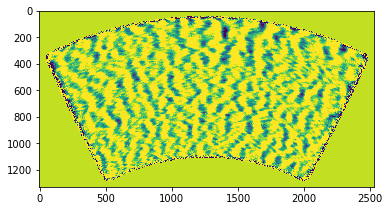

In [47]:
plt.imshow(galaxy_pairs.get_subarray(y_map_array,[1275,500],50),vmax=0.00001,vmin=-0.0001)

In [21]:
top_left_corner = np.array([330,52])
top_right_corner = np.array([330,2468])
bottom_right_corner = np.array([1275,2000])
bottom_left_corner = np.array([1275,2520-2000])

In [22]:
edges = np.vstack((top_left_corner,top_right_corner,bottom_left_corner,bottom_right_corner))

In [23]:
edges

array([[ 330,   52],
       [ 330, 2468],
       [1275,  520],
       [1275, 2000]])

In [24]:
temp1 = sptpol_software.observation.sky.pix2Ang(top_left_corner,np.array([0,-57.5]),reso_arcmin=1,map_pixel_shape=np.array([1320, 2520]))
# print(temp1[0]%360,temp1[1]%360)
# print(temp1)

In [25]:
sptpol_software.observation.sky.ang2Pix((0, -57.5),[0,-57.5],reso_arcmin=1,map_pixel_shape=np.array([1320,2520]))

([array([660]), array([1260])], (array([ True]), array([ True])))

In [26]:
temp2 = sptpol_software.observation.sky.pix2Ang(top_right_corner,np.array([0,-57.5]),reso_arcmin=1,map_pixel_shape=np.array([1320, 2520]))

In [27]:
temp3 = sptpol_software.observation.sky.pix2Ang(bottom_left_corner,np.array([0,-57.5]),reso_arcmin=1,map_pixel_shape=np.array([1320, 2520]))

In [28]:
temp4 = sptpol_software.observation.sky.pix2Ang(bottom_right_corner,np.array([0,-57.5]),reso_arcmin=1,map_pixel_shape=np.array([1320, 2520]))

In [29]:
edges_ang = np.array([temp1,temp2,temp3,temp4])
edges_ang = edges_ang.astype(int)
ra_range = np.array([edges_ang[0][0],edges_ang[1][0]])
dec_range = np.array([edges_ang[1][1],edges_ang[2][1]])
print(ra_range)
print(dec_range)

[-32  32]
[-52 -67]


In [30]:
# from ..constants import DTOR, RTOD
# def pixel_2_angle(pixel_coords,ra_dec_centre,reso_arcmin,map_pixel_shape):
    
    
#     pixel_coords = (y_coord, x_coord) = pixel_coords[0].astype(float), pixel_coords[1].astype(float)
#     n_pixels = map_pixel_shape.astype(float)
    
#     y_coord = (y_coord + 0.5 - 0.5 * n_pixels[0]) * reso_arcmin / 60
#     x_coord = (x_coord + 0.5 - 0.5 * n_pixels[1]) * reso_arcmin / 60
    
    

In [31]:
# print(max(df['RA']))
# print(min(df['RA']))
# print(max(df['DEC']))
# print(min(df['DEC']))


In [32]:
new_df = df[((df.DEC < dec_range[0]-0.03) & (df.DEC > dec_range[1]+0.03)) & ((df.RA > ra_range[0]+0.03) & (df.RA < ra_range[1]-0.03))]
new_df = new_df.reset_index(drop=True)
new_df

,ID,RA,DEC,ZREDMAGIC,ZREDMAGIC_E,weight,COMOVING,COMOVING_E,x_vec,y_vec,z_vec
0,3116904201,14.614882,-55.315130,0.150189,0.008762,0.965439,640.971123,38.697817,352.950511,92.034624,-527.066927
1,3116709409,14.072268,-55.076432,0.150201,0.008707,1.017144,641.022958,38.457989,355.961882,89.228306,-525.585275
2,3101091461,31.115454,-57.571104,0.150240,0.008810,0.988693,641.182868,38.909669,294.367489,177.682130,-541.195263
3,3108593254,23.761968,-52.442114,0.150288,0.009481,0.949766,641.377840,41.867809,357.817253,157.532579,-508.444524
4,3105601443,28.047881,-59.199564,0.150304,0.009179,0.887339,641.443503,40.537667,289.875847,154.440590,-550.971746
5,3118734965,12.625500,-53.306630,0.150308,0.008367,1.031016,641.460454,36.957027,374.025187,83.779332,-514.351725
6,3108979930,23.677374,-52.901443,0.150316,0.008251,0.940021,641.495151,36.446888,354.369810,155.390594,-511.655968
7,3105605347,28.113383,-59.130098,0.150318,0.008621,0.941977,641.504759,38.076872,290.315797,155.101354,-550.625702
8,3105697517,26.482030,-55.962096,0.150398,0.007907,0.877453,641.832327,34.930699,321.564394,160.200187,-531.865562
9,3110611898,21.789863,-53.271455,0.150477,0.009289,0.949284,642.156821,41.018902,356.587484,142.551642,-514.674440


In [33]:
cut_pairs = galaxy_pairs.getPairs(new_df,20)
cut_pairs_df = pd.DataFrame(cut_pairs.T,columns = ['galaxy_index_1','galaxy_index_2','Sep'])
cut_pairs_df['galaxy_index_1'] = cut_pairs_df.galaxy_index_1.astype(int)
cut_pairs_df['galaxy_index_2'] = cut_pairs_df.galaxy_index_2.astype(int)
cut_pairs_df

,galaxy_index_1,galaxy_index_2,Sep
0,39886,40108,16.313739
1,39886,39960,14.083859
2,39960,40108,14.121674
3,39328,39385,18.898123
4,39819,40108,17.283868
5,39532,39886,16.115064
6,39385,39663,14.026145
7,39663,40030,18.754300
8,40030,40084,12.612021
9,39385,39566,8.902526


In [34]:
len(cut_pairs_df.index)

192433

In [35]:
# index = np.random.randint(1,len(cut_pairs_df))
index = 72
index_2 = np.random.randint(1,len(cut_pairs_df))
print(cut_pairs_df.loc[index])
print(new_df.loc[cut_pairs_df.loc[index]['galaxy_index_1']])
print(new_df.loc[cut_pairs_df.loc[index]['galaxy_index_1']]['RA'])
print(new_df.loc[cut_pairs_df.loc[index]['galaxy_index_1']]['DEC'])

print(new_df.loc[cut_pairs_df.loc[index]['galaxy_index_2']])
print(new_df.loc[cut_pairs_df.loc[index]['galaxy_index_2']]['RA'])
print(new_df.loc[cut_pairs_df.loc[index]['galaxy_index_1']]['DEC'])


galaxy_index_1    38561.000000
galaxy_index_2    38876.000000
Sep                  17.038219
Name: 72, dtype: float64
ID             3.122085e+09
RA             7.429471e+00
DEC           -5.884892e+01
ZREDMAGIC      6.316505e-01
ZREDMAGIC_E    2.847941e-02
weight         9.585545e-01
COMOVING       2.370884e+03
COMOVING_E     1.252029e+02
x_vec          1.216154e+03
y_vec          1.585869e+02
z_vec         -2.029017e+03
Name: 38561, dtype: float64
7.4294709999999995
-58.848921999999995
ID             3.123462e+09
RA             7.446969e+00
DEC           -5.910975e+01
ZREDMAGIC      6.358944e-01
ZREDMAGIC_E    2.389912e-02
weight         9.927185e-01
COMOVING       2.384038e+03
COMOVING_E     1.051802e+02
x_vec          1.213630e+03
y_vec          1.586348e+02
z_vec         -2.045868e+03
Name: 38876, dtype: float64
7.446968999999999
-58.848921999999995


In [69]:
help(galaxy_pairs.get_subarray)

Help on function get_subarray in module galaxy_pairs:

get_subarray(array, centre, sqr_radius)
    Gets Sub Array with with an input centre in array space and half width from an input Array



In [70]:
def rescale_array(array,ra_dec_1,ra_dec_2,sqr_radius,width_of_pairs=100.):
    '''
    Rescales Array 
    '''
    pt1 = sptpol_software.observation.sky.ang2Pix(
        ra_dec_1, [0, -57.5], reso_arcmin=1, map_pixel_shape=np.array([1320, 2520]))
    pt2 = sptpol_software.observation.sky.ang2Pix(
        ra_dec_2, [0, -57.5], reso_arcmin=1, map_pixel_shape=np.array([1320, 2520]))

    X1 = float(pt1[0][0][0])
    X2 = float(pt2[0][0][0])
    
    Y1 = float(pt1[0][1][0])
    Y2 = float(pt2[0][1][0])

    sep = np.sqrt((X2-X1)**2 + (Y2 - Y1)**2)
    scale_fact = width_of_pairs/sep
    if sep == 0:
        return(np.zeros(shape=np.shape(array)))
    rescaled_array = sp.ndimage.zoom(array,scale_fact)

    centre = [len(rescaled_array)/2,len(rescaled_array)/2]

    new_array = get_subarray(array=rescaled_array,centre = centre,sqr_radius = sqr_radius)

    return(new_array)

In [37]:
test_pair = [cut_pairs_df.loc[index]['galaxy_index_1'],cut_pairs_df.loc[index]['galaxy_index_2']]
test_pair_2 = [cut_pairs_df.loc[index_2]['galaxy_index_1'],cut_pairs_df.loc[index_2]['galaxy_index_2']]

In [72]:
test_pair

[38809.0, 39127.0]

In [38]:
gal_coords_1 = galaxy_pairs.extract_ra_dec(cut_pairs_df.loc[index]['galaxy_index_1'],new_df)
gal_coords_2 = galaxy_pairs.extract_ra_dec(cut_pairs_df.loc[index]['galaxy_index_2'],new_df)
print(gal_coords_1)
print(gal_coords_2)
print(cut_pairs_df.loc[index])

(7.4294709999999995, -58.848921999999995)
(7.446968999999999, -59.109747)
galaxy_index_1    38561.000000
galaxy_index_2    38876.000000
Sep                  17.038219
Name: 72, dtype: float64


In [39]:
pt_1 = sptpol_software.observation.sky.ang2Pix(gal_coords_1, [0, -57.5], reso_arcmin=1, map_pixel_shape=np.array([1320, 2520]))
pt_2 = sptpol_software.observation.sky.ang2Pix(gal_coords_2, [0, -57.5], reso_arcmin=1, map_pixel_shape=np.array([1320, 2520]))
print(pt_1)
print(pt_2)


([array([740]), array([1490])], (array([ True]), array([ True])))
([array([756]), array([1489])], (array([ True]), array([ True])))


In [40]:
test_array = galaxy_pairs.cut_out_pair(pair=test_pair,y_map=k_map_rot,galaxy_catalogue=new_df,sqr_radius=30)
test_array_2 = galaxy_pairs.cut_out_pair(pair=test_pair_2,y_map=k_map_rot,galaxy_catalogue=new_df,sqr_radius=30)

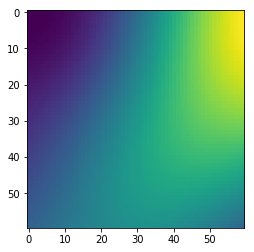

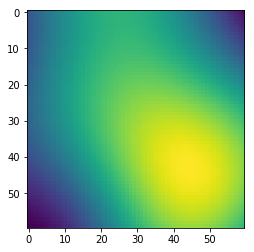

In [41]:
plt.imshow(test_array)
plt.show()
plt.imshow(test_array_2)
plt.show()

In [42]:
# plt.imshow(sp.ndimage.zoom(test_array,100./30.610455730027933))
# plt.show()
# print(len(sp.ndimage.zoom(test_array,100./30.610455730027933))/2)
# plt.imshow(galaxy_pairs.get_subarray(array=sp.ndimage.zoom(test_array,100./30.610455730027933),centre=[len(sp.ndimage.zoom(test_array,100./30.610455730027933))/2,len(sp.ndimage.zoom(test_array,100./30.610455730027933))/2],sqr_radius=100))
# # plt.imshow(sp.ndimage.zoom(test_array_2,100./57.48912940721924))
# plt.show()

In [43]:
rescale_test = galaxy_pairs.rescale_array(test_array,gal_coords_1,gal_coords_2,len(test_array)/2)

In [51]:
output = galaxy_pairs.stack_pairs_V2(k_map_rot,new_df,cut_pairs_df)

Added pair 241
Added pair 1651
Added pair 4042
Added pair 4048
Added pair 4098
Added pair 5407
Added pair 5836
Added pair 8874
Added pair 9272
Added pair 10987
Added pair 11031
Added pair 12635
Added pair 13056
Added pair 14492
Added pair 14516
Added pair 17719
Added pair 20938
Added pair 25421
Added pair 28011
Added pair 28174
Added pair 28753
Added pair 28955
Added pair 29514
Added pair 29519
Added pair 29649
Added pair 29732
Added pair 29834
Added pair 33313
Added pair 33472
Added pair 42037
Added pair 42505
Added pair 51325
Added pair 51568
Added pair 52724
Added pair 53005
Added pair 53006
Added pair 53923
Added pair 55280
Added pair 56383
Added pair 56895
Added pair 59390
Added pair 61292
Added pair 61401
Added pair 62079
Added pair 62712
Added pair 62852
Added pair 62975
Added pair 63870
Added pair 65440
Added pair 65521
Added pair 66459
Added pair 68688
Added pair 71083
Added pair 76799
Added pair 79350
Added pair 79365
Added pair 81209
Added pair 81712
Added pair 81849
Added p

ValueError: -1 cannot contain negative values.

In [ ]:
plt.imshow(output)

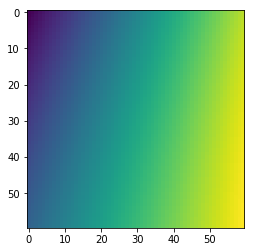

In [46]:
plt.imshow(rescale_test)

In [47]:
print(output)

NameError: name 'output' is not defined

In [48]:
print(np.shape(test))
print(np.shape(test_array))

NameError: name 'test' is not defined